# ICA03 — Sea Breezes and input soundings! (part 1, derecho-free)

This notebook is a streamlined introduction to reading and plotting WRF wrfout files with xarray.

Julie.Lundquist@JHU.edu 

2026 January 27 (updated from August 24, 2023, updated from September 8, 2021)

## Learning goals:
By the end, you should be able to:

1. Read an input sounding, plot the profiles, and interpret stability

2. Read a wrfout file, plot the land use characteristics

3. Demonstrate destaggering of velocities

4. Read a wrfout file, plot contours of winds of a sea breeze


<style>
/* Light touch styling for readability */
.rendered_html, .jp-RenderedHTMLCommon {font-size: 16px; line-height: 1.5;}
.rendered_html h1, .jp-RenderedHTMLCommon h1 {font-size: 2.0em;}
.rendered_html h2, .jp-RenderedHTMLCommon h2 {font-size: 1.6em;}
.rendered_html h3, .jp-RenderedHTMLCommon h3 {font-size: 1.3em;}
code, pre {font-size: 13px;}
</style>

> **Tip:** Run cells from top to bottom. And be sure to save your edited version of this in a student_work directory!

In [1]:
# Plot/print defaults for nicer visuals
import matplotlib as mpl
mpl.rcParams.update({
    "figure.dpi": 110,
    "savefig.dpi": 200,
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
})
import pandas as pd
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [88]:
# --- Imports (run once) ---
from __future__ import annotations

from pathlib import Path
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
print("Imports OK")

Imports OK


In [4]:

# Modify these to point to your own files
INPUT_SOUNDING_DIRECTORY = './seabreezeU00ms'
INPUT_SOUNDING_FILE = 'input_sounding'


# 1) Read in the input_sounding text file 

In this example, we will read in the input sounding and create simple line plots of the variables in the file. You may have done this first step in excel for the @home activities, so here we'll do it in python


> **Update:** The next cell reads the file into a `pandas.DataFrame` and makes quick-look plots so you can focus on interpretation rather than file parsing.

In [5]:
# Read the WRF `input_sounding` file header (first line) safely

sounding_path = Path(INPUT_SOUNDING_DIRECTORY) / INPUT_SOUNDING_FILE
print(f"Looking at sounding: {sounding_path.resolve()}")

if not sounding_path.exists():
    raise FileNotFoundError(f"Couldn't find {sounding_path}. Check INPUT_SOUNDING_DIRECTORY and INPUT_SOUNDING_FILE.")

with sounding_path.open("r") as f:
    header = f.readline().strip()

print("Header line:")
print(header)

# The header typically contains the initial time and location metadata for the sounding.
# We'll parse the profile data below.

Looking at sounding: /home/jlundqui/EN530.462/AtmosphericModelingLab/ICA03/seabreezeU00ms/input_sounding
Header line:
1000.0         300.5000        5.00000


What does this first line mean? 

We can discover this by looking
at the WRF code itself, which I hope you did in the at-home activity:
https://github.com/wrf-model/WRF/blob/master/dyn_em/module_initialize_ideal.F 
and read the code around line 1950
to see that WRF reads in three paramters from this first line.

The first (which it stores as 'ps') is surface pressure in mb.

The second is surface potential temperature (stored as 'ts') in Kelvin.

The third is surface mixing ratio (stored as qvs) in g/kg.

Now let's read in the columns of data in the rest of the file

In [40]:
def read_wrf_input_sounding(path: str | Path) -> pd.DataFrame:
    """Read a WRF `input_sounding` file into a tidy DataFrame.

    The file format is:
      - 1 header line of surface data
      - then rows of (pressure, height, temperature, dewpoint, wind_dir, wind_speed)
        (exact columns can vary slightly by case; we keep it flexible)
    """
    path = Path(path)
    with path.open("r") as f:
        lines = f.readlines()

    data_lines = [ln for ln in lines[1:] if ln.strip() and not ln.strip().startswith("#")]

    # Split on whitespace; keep only numeric rows
    rows = []
    for ln in data_lines:
        parts = ln.split()
        try:
            rows.append([float(x) for x in parts])
        except ValueError:
            # Skip any non-numeric lines
            continue

    arr = np.asarray(rows)
    if arr.size == 0:
        raise ValueError("No numeric data rows found after the header. Open the file and inspect its formatting.")

    # Best-effort column naming by number of fields
    colmap = {
        5: ["z_m", "Th_K", "q_gkg", "u_mps", "v_mps"],
    }
    cols = colmap.get(arr.shape[1], [f"col{i}" for i in range(arr.shape[1])])
    df = pd.DataFrame(arr, columns=cols)

    # Convenience conversions
    if "Th_K" in df:
        df["Th_C"] = df["Th_K"] - 273.15
    if "Td_K" in df:
        df["Td_C"] = df["Td_K"] - 273.15
    if "u_mps" in df and "v_mps" in df:
        u = df["u_mps"].to_numpy()
        v = df["v_mps"].to_numpy()

        # Wind speed
        df["ws_mps"] = np.hypot(u, v)

        # Wind direction (meteorological: coming FROM, clockwise from north) (will be 180 for 0 wind, OK)
        df["wd_deg"] = (np.degrees(np.arctan2(-u, -v)) + 360) % 360
        
#         df.loc[df["ws_mps"] < 0.5, "wd_deg"] = np.nan # Turn on to make wind directions NaN for wind speeds less than 0.5 m/s
 
    return df

sounding_df = read_wrf_input_sounding(sounding_path)
sounding_df.head()

,z_m,Th_K,q_gkg,u_mps,v_mps,Th_C,ws_mps,wd_deg
0,125.0,300.5000,5.0,0.0,0.0,27.3500,0.0,180.0
1,375.0,300.5650,5.0,0.0,0.0,27.4150,0.0,180.0
2,625.0,301.0699,5.0,0.0,0.0,27.9199,0.0,180.0
3,875.0,301.6293,5.0,0.0,0.0,28.4793,0.0,180.0
4,1125.0,302.2307,5.0,0.0,0.0,29.0807,0.0,180.0


[OK] Saved figure → input_sounding.png


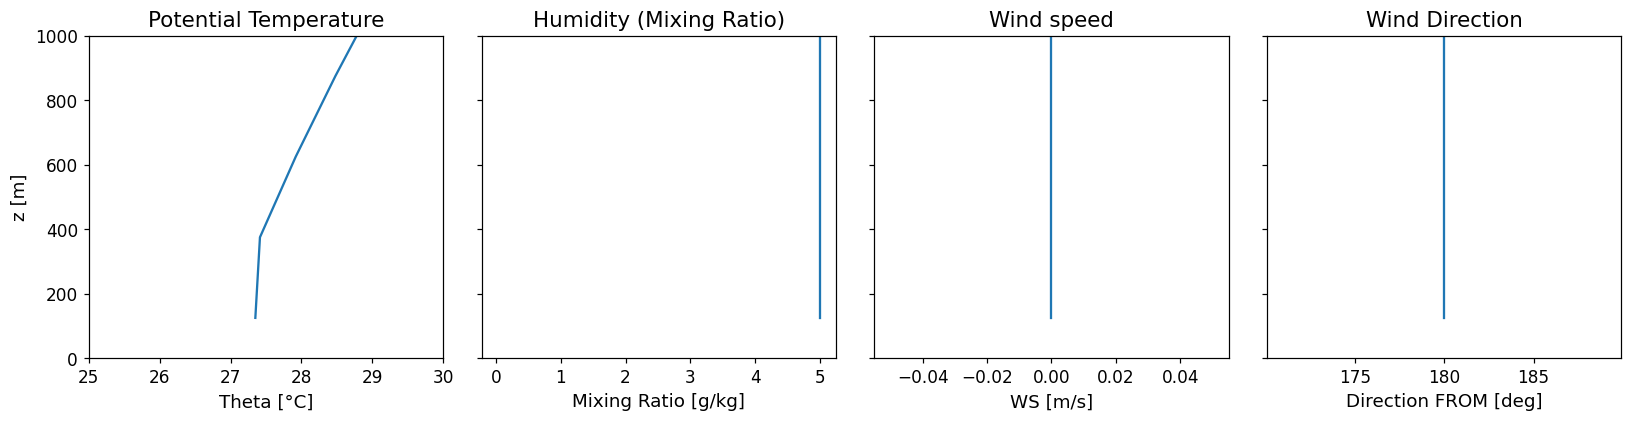

In [73]:
def plot_sounding(df: pd.DataFrame) -> None:
    """Quick-look plots for the input sounding."""
    fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)
    
    y_lim=[0,1000] # good limits for height  <--- change this to see the tropopause


    # Potential Temperature
    if "Th_C" in df:
        axes[0].plot(df["Th_C"], df["z_m"])
        axes[0].set_xlabel("Theta [°C]")
    else:
        axes[0].plot(df.iloc[:,2], df["z_m"])
        axes[0].set_xlabel(df.columns[2])
    axes[0].set_ylabel("z [m]")
    axes[0].set_title("Potential Temperature")
    axes[0].set_ylim(y_lim)
    axes[0].set_xlim([25,30]) # reasonable surface temeprature limits in C

    # Mixing ratio (if present)
    if "q_gkg" in df:
        axes[1].plot(df["q_gkg"], df["z_m"])
        axes[1].set_xlabel("Mixing Ratio [g/kg]")
        axes[1].set_title("Humidity (Mixing Ratio)")
    else:
        axes[1].axis("off")
    axes[0].set_ylim(y_lim)

        
    # Wind speed
    if "ws_mps" in df:
        axes[2].plot(df["ws_mps"], df["z_m"])
        axes[2].set_xlabel("WS [m/s]")
        axes[2].set_title("Wind speed")
    else:
        axes[2].axis("off")
        
    axes[2].set_ylim(y_lim)

    # Wind direction
    if "wd_deg" in df:
        axes[3].plot(df["wd_deg"], df["z_m"])
        axes[3].set_xlabel("Direction FROM [deg]")
        axes[3].set_title("Wind Direction")
    else:
        axes[3].axis("off")
        
    axes[2].set_ylim(y_lim)

    plt.tight_layout()

    save='input_sounding.png'
    fig.savefig(save, dpi=200)
    print(f"[OK] Saved figure → {save}")    
    
    plt.show()

plot_sounding(sounding_df)

# 2) Make a new line plot by copying and pasting the text above into this cell and modifying as directed in the in-class activity

In [10]:
# empty cell for copying-pasting

# remember to change both the x- and y- axis limits so that you can see an inversion at the tropopause



# 3) Now look at output from the default seabreeze run

In [39]:

WRFOUT_DIRECTORY = "./seabreezeU00ms/"
# file_path = "./seabreezeU01ms/"
# file_path = "./seabreezeU05ms/"
# file_path = "./seabreezeU10ms/"

filename = "wrfout_d01_2007-06-01_05:00:00"

start = file_path.find('seabreeze')+9
label_stub = file_path[start:start+5]


print('We will use ',label_stub, 'to label plots')

We will use  U00ms to label plots


## 3.1 Understanding the physical setup of the 2D sea breeze

Now let's start looking at the results of the simulations. First, because the sea breeze is driven by the temperature difference between the land and the water, we'll look at what is land and what is water in the simulation.


In [41]:
# Open one WRF output file and inspect land/sea masks

wrfout_path = Path(WRFOUT_DIRECTORY) / filename
print(f"Looking at wrfout: {wrfout_path.resolve()}")

if not wrfout_path.exists():
    raise FileNotFoundError(f"Couldn't find {wrfout_path}. Check WRFOUT_DIRECTORY and filename.")

df = xr.open_dataset(wrfout_path)
df

Looking at wrfout: /home/jlundqui/EN530.462/AtmosphericModelingLab/ICA03/seabreezeU00ms/wrfout_d01_2007-06-01_05:00:00


<xarray.Dataset>
Dimensions:                (Time: 49, south_north: 2, west_east: 201,
                            bottom_top: 34, bottom_top_stag: 35,
                            soil_layers_stag: 5, west_east_stag: 202,
                            south_north_stag: 3, seed_dim_stag: 2)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/161)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/129)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2007-06-01_05:00:00
    SIMULATION_START_DATE:           2007-06-01_05:00:00
    WEST-EAST_GRID_DIMENSION:        202
    SOUTH-NORTH_GRID_DIMENSION:      3
    BOTTOM-TOP_GRID_DIMENSION:       35
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [50]:
xland = df["XLAND"].isel(Time=0, south_north=0)  # 1=land, 2=water 
print(np.min(xland),np.max(xland))
lu_index = df["LU_INDEX"].isel(Time=0, south_north=0)  # land use categories, see 
print(np.min(lu_index),np.max(lu_index))

<xarray.DataArray 'XLAND' ()>
array(1., dtype=float32)
Coordinates:
    XTIME    datetime64[ns] 2007-06-01T05:00:00 <xarray.DataArray 'XLAND' ()>
array(2., dtype=float32)
Coordinates:
    XTIME    datetime64[ns] 2007-06-01T05:00:00
<xarray.DataArray 'LU_INDEX' ()>
array(16., dtype=float32)
Coordinates:
    XTIME    datetime64[ns] 2007-06-01T05:00:00 <xarray.DataArray 'LU_INDEX' ()>
array(18., dtype=float32)
Coordinates:
    XTIME    datetime64[ns] 2007-06-01T05:00:00


[OK] Saved figure → surface.png


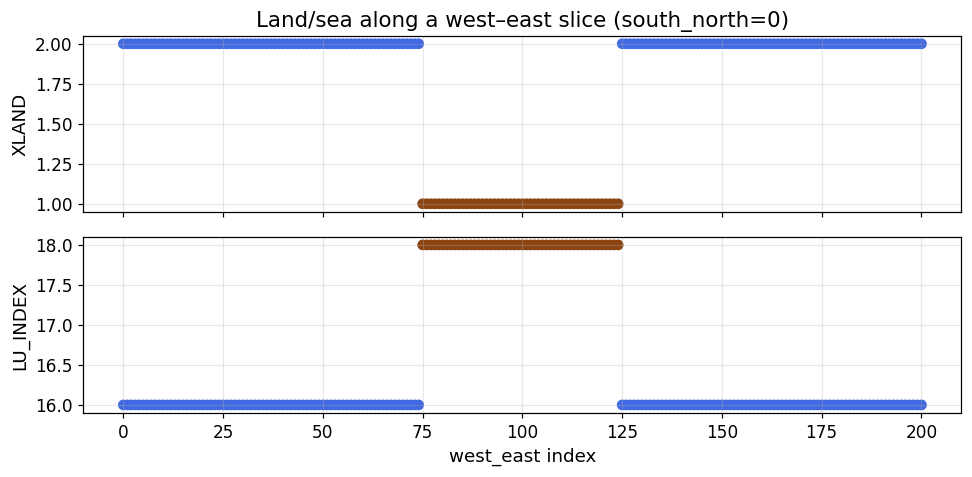

In [75]:
xland = df["XLAND"].isel(Time=0, south_north=0)  # 1=land, 2=water in many WRF setups
lu_index = df["LU_INDEX"].isel(Time=0, south_north=0) # values are 16 and 18 

x = df["west_east"].values
DX = df.attrs['DX'] / 1000. # units of km
x_km = x * DX


# Color maps for categorical variables
xland_colors = {
    1: "saddlebrown",  # land
    2: "royalblue",    # water
}

lu_colors = {
    18: "saddlebrown",  # e.g. cropland / land-use
    16: "royalblue",    # water
}

# Map values to colors
xland_c = [xland_colors[int(v)] for v in xland.values]
lu_c    = [lu_colors[int(v)]    for v in lu_index.values]

fig, ax = plt.subplots(2, 1, figsize=(9, 4.5), sharex=True)

ax[0].scatter(x, xland, c=xland_c)
ax[0].set_ylabel("XLAND")
ax[0].set_title("Land/sea along a west–east slice (south_north=0)")

ax[1].scatter(x, lu_index, c=lu_c)
ax[1].set_ylabel("LU_INDEX")
ax[1].set_xlabel("west_east index")

for a in ax:
    a.grid(True, alpha=0.3)

plt.tight_layout()

save='surface.png'
fig.savefig(save, dpi=200)
print(f"[OK] Saved figure → {save}")

plt.show()


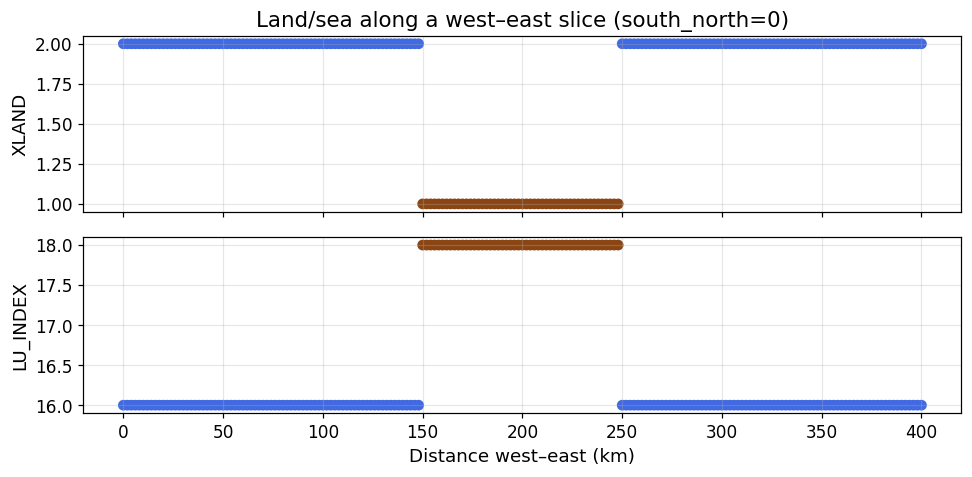

In [59]:
# Modify the x-axis to use the dx so the distances are in km.

# Grid spacing in km
DX = df.attrs["DX"] / 1000.0

# Convert index → distance
x_km = x * DX

fig, ax = plt.subplots(2, 1, figsize=(9, 4.5), sharex=True)

ax[0].scatter(x_km, xland, c=xland_c)
ax[0].set_ylabel("XLAND")
ax[0].set_title("Land/sea along a west–east slice (south_north=0)")

ax[1].scatter(x_km, lu_index, c=lu_c)
ax[1].set_ylabel("LU_INDEX")
ax[1].set_xlabel("Distance west–east (km)")

for a in ax:
    a.grid(True, alpha=0.3)

plt.tight_layout()

save='surface2.png'
fig.savefig(save, dpi=200)
print(f"[OK] Saved figure → {save}")

plt.show()


[OK] Saved figure → surface3.png


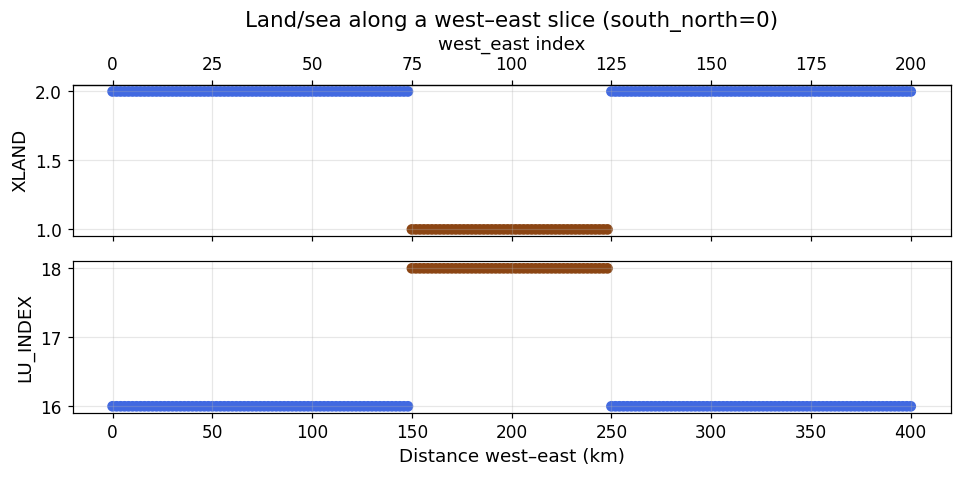

In [76]:
# Sometimes it's nicer to combine them both into one 

fig, ax = plt.subplots(2, 1, figsize=(9, 4.5), sharex=True)

# Bottom axis: distance in km
ax[0].scatter(x_km, xland, c=xland_c)
ax[0].set_ylabel("XLAND")
ax[0].set_title("Land/sea along a west–east slice (south_north=0)")

ax[1].scatter(x_km, lu_index, c=lu_c)
ax[1].set_ylabel("LU_INDEX")
ax[1].set_xlabel("Distance west–east (km)")

# --- Top axis: grid index ---
ax_top = ax[0].secondary_xaxis(
    "top",
    functions=(
        lambda km: km / DX,   # km → index
        lambda idx: idx * DX  # index → km
    ),
)
ax_top.set_xlabel("west_east index")

for a in ax:
    a.grid(True, alpha=0.3)

plt.tight_layout()

save='surface3.png'
fig.savefig(save, dpi=200)
print(f"[OK] Saved figure → {save}")

plt.show()


## 3.2 Assessing thermodynamic forcing from a run with the 2D sea breeze

Because the sea breeze is driven by the temperature difference between the land and the water, we'll look at how the shortwave radiation that heats the surface changes throughout the simulation.


This cell also shows you how to use "where" to find important values in an array 

In [61]:
# Understand the time series of solar radiation

SWDOWN = df['SWDOWN']

# print(np.shape(SWDOWN))

print('The max value of incoming solar radiaton is ',int(np.max(SWDOWN)), 'W m-2')

here = (np.where(SWDOWN[:,0,0] == np.max(SWDOWN[:,0,0])))    # SWDOWN is of shape (time, s_n, w_e)
# print(int(SWDOWN[here[0],0,0]))
print('Max incoming solar radiation occurs at ',(pd.to_datetime(df['XTIME'].values[here[0]]).strftime('%d %H:%M')))



The max value of incoming solar radiaton is  1041 W m-2
Max incoming solar radiation occurs at  Index(['01 12:00'], dtype='object')


[OK] Saved figure → swdown.png


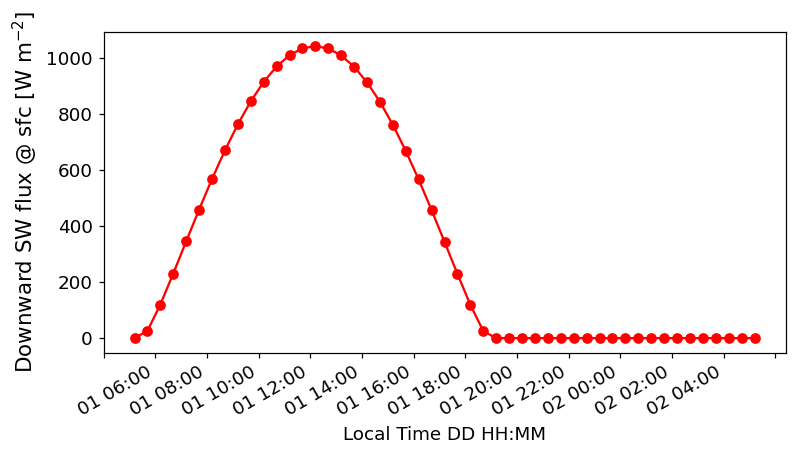

In [77]:
## Set up the figure and axis
fig = plt.figure(figsize=(8,4))

# Only one plot 
ax1 = fig.add_subplot(1,1,1)

x_axis = pd.to_datetime(df['XTIME'].values).strftime('%d %H:%M')
y_axis = SWDOWN.mean(dim=['south_north','west_east'])


# the x-axis is ...
# the y-axis is ...
im1 = ax1.plot(x_axis,y_axis, color='r', marker='o') 

# Necessary labels for the plot
ax1.xaxis.set_visible(True)
ax1.yaxis.set_visible(True)
ax1.tick_params(labelsize=12)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 4)) # label every 4th time
ax1.set_xlabel("Local Time DD HH:MM", fontsize=12) # redundant with bottom plot
ax1.set_ylabel("Downward SW flux @ sfc [W m$^{-2}$]", fontsize=14)
fig.autofmt_xdate()


plt.gcf().subplots_adjust(bottom=0.15)

save='swdown.png'
fig.savefig(save, dpi=200)
print(f"[OK] Saved figure → {save}")

plt.show()



## 3.3 Assessing thermodynamic output from a run with the 2D sea breeze

Because the sea breeze is driven by the temperature difference between the land and the water, we'll look at the time series of the difference between the land and water temperature (stored in variable TSK).

[OK] Saved figure → tsk.png


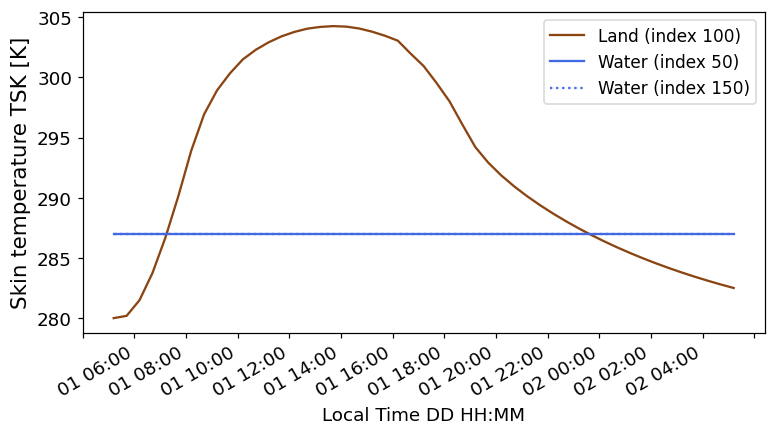

In [78]:
# Indices to sample
land_index   = 100
water_index1 = 50
water_index2 = 150

# Set up the figure and axis
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)

# Time axis
x_axis = pd.to_datetime(df['XTIME'].values).strftime('%d %H:%M')

# Extract skin temperature time series (choose south_north=0 slice)
tsk_land   = df["TSK"].isel(south_north=0, west_east=land_index)
tsk_water1 = df["TSK"].isel(south_north=0, west_east=water_index1)
tsk_water2 = df["TSK"].isel(south_north=0, west_east=water_index2)

# Plot
ax1.plot(x_axis, tsk_land,   color="saddlebrown", label="Land (index 100)")
ax1.plot(x_axis, tsk_water1, color="royalblue",   linestyle="-", label="Water (index 50)")
ax1.plot(x_axis, tsk_water2, color="royalblue",   linestyle=":", label="Water (index 150)")

# Axis formatting
ax1.xaxis.set_visible(True)
ax1.tick_params(labelsize=12)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 4)) # label every 4th time
ax1.set_xlabel("Local Time DD HH:MM", fontsize=12) # redundant with bottom plot
fig.autofmt_xdate()


# ax1.set_xlabel("Local Time (DD HH:MM)", fontsize=12)
ax1.set_ylabel("Skin temperature TSK [K]", fontsize=14)
ax1.legend()

plt.gcf().subplots_adjust(bottom=0.15)

save='tsk.png'
fig.savefig(save, dpi=200)
print(f"[OK] Saved figure → {save}")


plt.show()


## 3.4 Assessing thermodynamic output from a run with the 2D sea breeze

How does that temperature difference manifest in the winds at 10m? Why do we only look at the U winds here and not the V winds?

[OK] Saved figure → u10.png


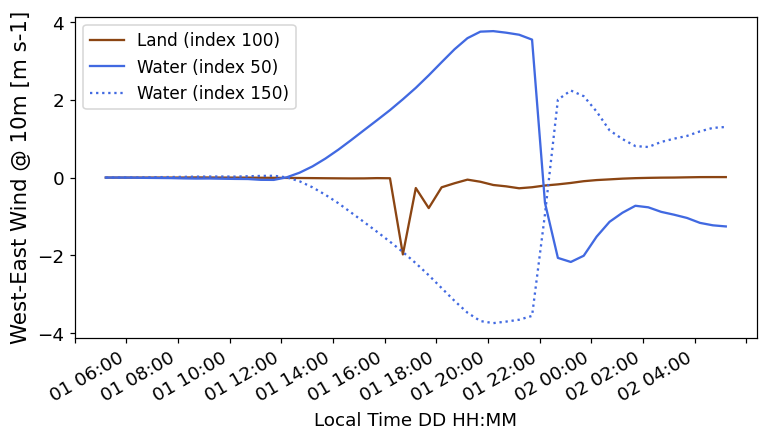

In [79]:
# What about the wind differences?

U10 = df['U10']
V10 = df['V10']


# # Indices to sample # Assume we're using the same as above
# land_index   = 100
# water_index1 = 50
# water_index2 = 150

# Set up the figure and axis
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)

# Time axis
x_axis = pd.to_datetime(df['XTIME'].values).strftime('%d %H:%M')

# Extract skin temperature time series (choose south_north=0 slice)
u10_land   = df["U10"].isel(south_north=0, west_east=land_index)
u10_water1 = df["U10"].isel(south_north=0, west_east=water_index1)
u10_water2 = df["U10"].isel(south_north=0, west_east=water_index2)

# Plot
ax1.plot(x_axis, u10_land,   color="saddlebrown", label="Land (index 100)")
ax1.plot(x_axis, u10_water1, color="royalblue",   linestyle="-", label="Water (index 50)")
ax1.plot(x_axis, u10_water2, color="royalblue",   linestyle=":", label="Water (index 150)")

# Axis formatting
ax1.xaxis.set_visible(True)
ax1.tick_params(labelsize=12)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 4)) # label every 4th time
ax1.set_xlabel("Local Time DD HH:MM", fontsize=12) # redundant with bottom plot
fig.autofmt_xdate()


# ax1.set_xlabel("Local Time (DD HH:MM)", fontsize=12)
ax1.set_ylabel("West-East Wind @ 10m [m s-1]", fontsize=14)
ax1.legend()

plt.gcf().subplots_adjust(bottom=0.15)

save='u10.png'
fig.savefig(save, dpi=200)
print(f"[OK] Saved figure → {save}")

plt.show()


## 3.5 Assessing wind (& pressure & temperature) spatial variability from a run with the 2D sea breeze - but first we need to destagger
Before we assess the thermodynamic variables at heights other than 10m, we need to remember to destagger the u-values. Let's check the shapes of some important model output fields

In [82]:
U = df['U']
W = df['W']
PH = df['PH']
P = df['P']
PHB = df['PHB']

print("U:",np.shape(U)) 
print("W:",np.shape(W))
print("PH:",np.shape(PH))
print("P:",np.shape(P))
print("PHB:",np.shape(PHB))

# Compare this to the output of the header.txt

# netcdf wrfout_d01_2007-06-01_05\:00\:00 {
# dimensions:
#         Time = UNLIMITED ; // (49 currently)
#         DateStrLen = 19 ;
#         west_east = 201 ;
#         south_north = 2 ;
#         bottom_top = 34 ;
#         bottom_top_stag = 35 ;
#         soil_layers_stag = 5 ;
#         west_east_stag = 202 ;
#         south_north_stag = 3 ;
#         seed_dim_stag = 2 ;

# Write out the dimensions of U, W, PH, PHB
# U (time,bottom_top,south_north,west_east_stag)
# W (time,bottom_top_stag,south_north,west_east)
# PH (time,bottom_top_stag,south_north,west_east)
# PHB (time,bottom_top_stag,south_north,west_east)

# And note which dimension is the staggered dimension!

U: (49, 34, 2, 202)
W: (49, 35, 2, 201)
PH: (49, 35, 2, 201)
P: (49, 34, 2, 201)
PHB: (49, 35, 2, 201)


In [81]:
# Let's de-stagger, defining a destagger function:
def destagger(var, stagger_dim):
    '''
    From wrf-python https://github.com/NCAR/wrf-python/blob/b40d1d6e2d4aea3dd2dda03aae18e268b1e9291e/src/wrf/destag.py 
    '''
    var_shape = var.shape
    num_dims = var.ndim
    stagger_dim_size = var_shape[stagger_dim]

    full_slice = slice(None)
    slice1 = slice(0, stagger_dim_size - 1, 1)
    slice2 = slice(1, stagger_dim_size, 1)

    dim_ranges_1 = [full_slice] * num_dims
    dim_ranges_2 = [full_slice] * num_dims

    dim_ranges_1[stagger_dim] = slice1
    dim_ranges_2[stagger_dim] = slice2

    result = .5*(var[tuple(dim_ranges_1)] + var[tuple(dim_ranges_2)])

    return result

## 3.6 Assessing wind (& pressure & temperature) spatial variability from a run with the 2D sea breeze - but first we need to destagger
Now that we know how to destagger, let's use those destaggered variables to understand these simulations.

DX = 2.0 km
Plotting data for  2007-06-01 11:00


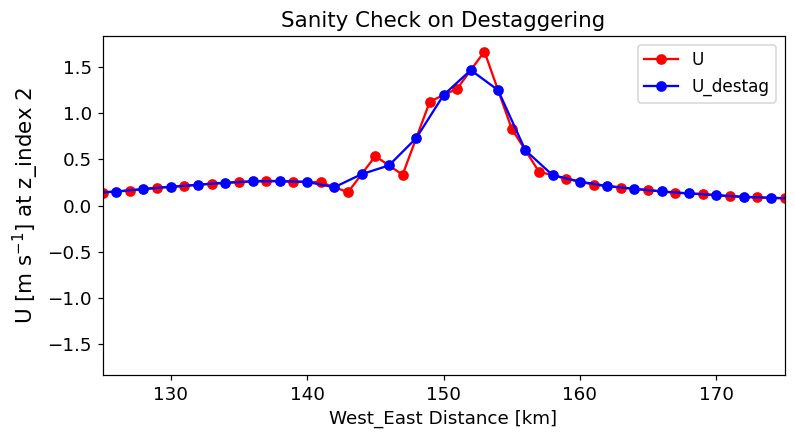

In [85]:
# Now we destagger and make plots

df['U_destag'] = (('Time', 'bottom_top', 'south_north', 'west_east'), destagger(df['U'].values, 3))
U_destag = df['U_destag']
DX = df.attrs['DX'] / 1000. # units of km
print('DX =',DX,'km')
Times = pd.to_datetime(df['XTIME'].values).strftime('%Y-%m-%d %H:%M')
# print(Times)

# print(np.shape(df['U'])) 
# print(np.shape(df['U_destag'])) 

# What does U look like?

# print(df['west_east'])
# print(df['west_east_stag'])

fig = plt.figure(figsize=(8,4))

# Only one plot 
ax1 = fig.add_subplot(1,1,1)

########## Change this time_index to look at other times
time_index = 12
print('Plotting data for ', Times[time_index])
height_index = 2
y_index = 0

# Remember how the staggering works when creating the axes
x_axis_staggered = DX*df['west_east_stag'] - 0.5*DX
x_axis_unstaggered = DX*df['west_east']

im1 = ax1.plot(x_axis_staggered,U[time_index,height_index,y_index,:], color='r', marker='o',
              label='U') 
im1 = ax1.plot(x_axis_unstaggered,U_destag[time_index,height_index,y_index,:], color='b', marker='o',
              label='U_destag') 

# Necessary labels for the plot
ax1.xaxis.set_visible(True)
ax1.yaxis.set_visible(True)
ax1.tick_params(labelsize=12)
start, end = ax1.get_xlim()
# ax1.xaxis.set_ticks(np.arange(start, end, 4)) # label every 4th time
ax1.set_xlabel("West_East Distance [km]", fontsize=12) # redundant with bottom plot
ax1.set_ylabel("U [m s$^{-1}$] at z_index "+str(height_index), fontsize=14)
ax1.legend()
ax1.set_title('Sanity Check on Destaggering')

# Zoom in on where the winds are interesting
ax1.set_xlim(125,175)

# save='destagU10.png'
# fig.savefig(save, dpi=200)
# print(f"[OK] Saved figure → {save}")

plt.show()

# print(x_axis_staggered)
# print(x_axis_unstaggered)

## Assessing wind (& pressure & temperature) spatial variability from a run with the 2D sea breeze
Now let's look at the spatial variability at a given time, defined by an index labelled "one_time_index". This code will create a six-panel plot that lets you assess the development of the seabreeze in time. Find one_time_index and change it to explore the temporal variability of the sea breeze (starting at one_time_index =1). Before running this, it would be good to verify the maximum and minimum wind speeds for your case. These U_levels values are for the 0 m/s forcing.


(49, 34, 2, 201)
(49, 34, 2, 201)
DX = 2.0 km
Plotting data for  2007-06-01 11:00
[OK] Saved figure → U00ms_contours_12.png


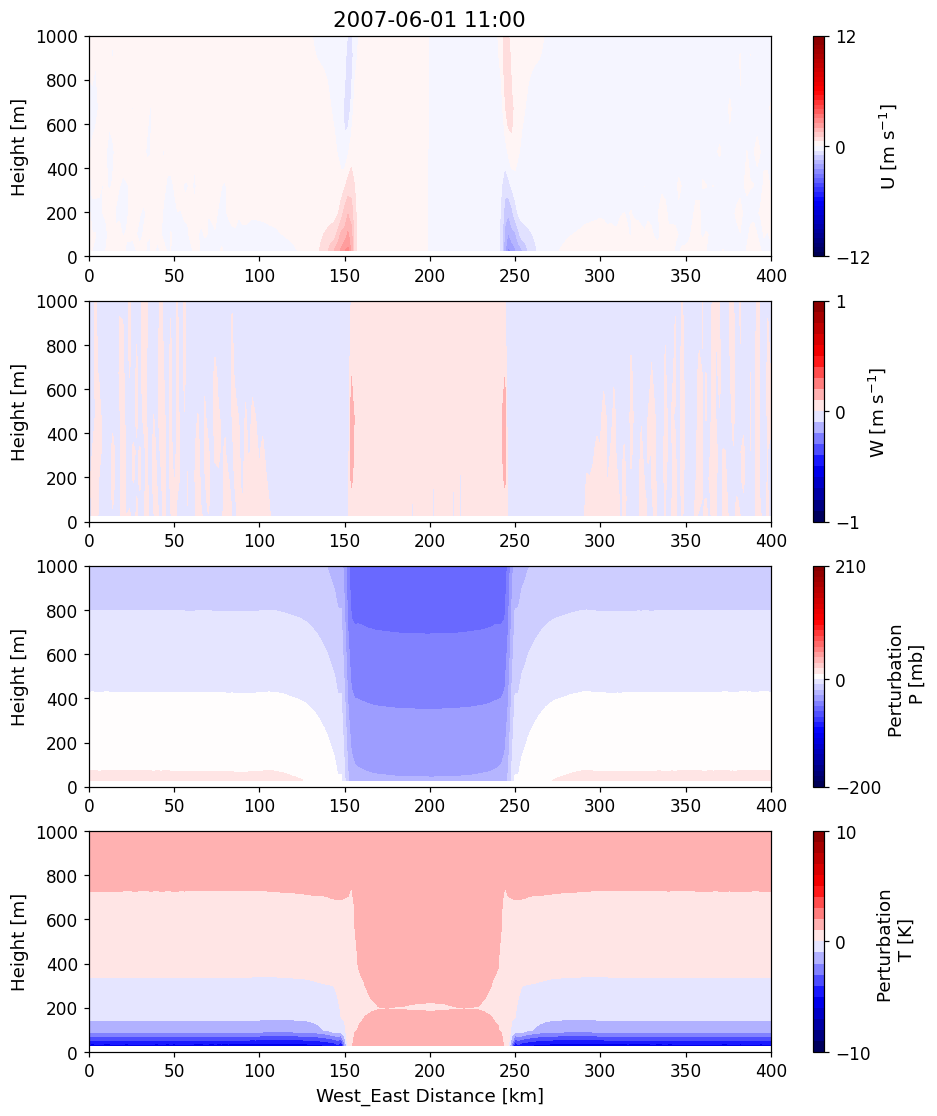

In [89]:
# Read in the useful values

Times = pd.to_datetime(df['XTIME'].values).strftime('%Y-%m-%d %H:%M')
# print(Times)

# Use the destaggering routine, noting which dimension was staggered
df['U_destag'] = (('Time', 'bottom_top', 'south_north', 'west_east'), destagger(df['U'].values, 3))
U_destag = df['U_destag']

df['W_destag'] = (('Time', 'bottom_top', 'south_north', 'west_east'), destagger(df['W'].values, 1))
W_destag = df['W_destag']

# T doesn't need to be destaggered
print(np.shape(df['T'].values))
T_destag = df['T'] # Just calling it destaggered for convenience

# P doesn't need to be destaggered
print(np.shape(df['P'].values))
P_destag = df['P'] # Just calling it destaggered for convenience

# But PH and PHB do need to be destaggered
# PH (time,bottom_top_stag,south_north,west_east)
# PHB (time,bottom_top_stag,south_north,west_east)

df['PH_destag'] = (('Time', 'bottom_top', 'south_north', 'west_east'), destagger(df['PH'].values, 1))
PH_destag = df['PH_destag']

df['PHB_destag'] = (('Time', 'bottom_top', 'south_north', 'west_east'), destagger(df['PHB'].values, 1))
PHB_destag = df['PHB_destag']

T2 = df['T2']
Z = (PH_destag+PHB_destag)/9.81 # units of m

DX = df.attrs['DX'] / 1000. # units of km
print('DX =',DX,'km')

x_axis = DX*df['west_east'] # assume unstaggered

# Make a 6-panel plot with contours of u, w, th, and p, and then 2D plots of TSK and T2

########### Look here to change the plotting time index
########## Change this time_index to look at other times
time_index = 12
print('Plotting data for ', Times[time_index])
###########

thisU = U_destag[time_index,:,0,:]
thisW = W_destag[time_index,:,0,:]
thisP = P_destag[time_index,:,0,:]
thisT = T_destag[time_index,:,0,:]
testz = Z[time_index,:,0,0]
thisTimes = Times[time_index] # use this to label the plot

thisTSK = TSK[time_index,0,:]
thisT2 = T2[time_index,0,:]

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 12}

# matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,12))

ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)

cmap = cm.seismic # diverging color table centered around 0

## Define contour levels
# maybe change these ranges to reflect max/min values for stronger forcing
# Look carefully at how I defined these ranges to force them to be symmetric around zero - the range seems large
# but for later simulations you'll want the bigger range.
U_levels = np.arange(-4, 4.5, 0.5)
U_levels = np.arange(-12, 12.5, 0.5) # for 10 m/s forcing
W_levels = np.arange(-1, 1.1, 0.1)
P_levels = np.arange(-200, 220, 10)
T_levels = np.arange(-10, 11, 1)

# Top Figure: U
im1 = ax1.contourf(x_axis, testz, thisU, U_levels, 
                     cmap=cm.get_cmap(cmap, len(U_levels) -1 ))
fig.colorbar(im1, ax=ax1, ticks=[np.min(U_levels), 0, np.max(U_levels)],
            label = 'U [m s$^{-1}$]')
ax1.set_ylabel("Height [m]", fontsize=12) 
ax1.set_title(thisTimes,fontsize=14)

# Second Figure: W
im2 = ax2.contourf(x_axis, testz, thisW, W_levels, 
                     cmap=cm.get_cmap(cmap, len(W_levels) - 1))
fig.colorbar(im2, ax=ax2, ticks=[np.min(W_levels), 0, np.max(W_levels)],
            label = 'W [m s$^{-1}$]')
ax2.set_ylabel("Height [m]", fontsize=12) 

# Third figure: P
im3 = ax3.contourf(x_axis, testz, thisP, P_levels, 
                     cmap=cm.get_cmap(cmap, len(P_levels) - 1))
fig.colorbar(im3, ax=ax3, ticks=[np.min(P_levels), 0, np.max(P_levels)],
            label = 'Perturbation \n P [mb]')
ax3.set_ylabel("Height [m]", fontsize=12) 

# Fourth figure: T
im4 = ax4.contourf(x_axis, testz, thisT, T_levels, 
                     cmap=cm.get_cmap(cmap, len(T_levels) - 1))
fig.colorbar(im4, ax=ax4, ticks=[np.min(T_levels), 0, np.max(T_levels)],
            label = 'Perturbation \n T [K]')
ax4.set_xlabel("West_East Distance [km]", fontsize=12) 
ax4.set_ylabel("Height [m]", fontsize=12) 


ax1.set_ylim(0,1000)
ax2.set_ylim(0,1000)
ax3.set_ylim(0,1000)
ax4.set_ylim(0,1000)

plot_fname = label_stub+"_contours_"+str(time_index)
save=plot_fname+'.png'
fig.savefig(save, dpi=200)
print(f"[OK] Saved figure → {save}")

plt.show()


In [91]:
# Let's instead make a function so that we can eventually make animations to see the flow evolve

# Precompute Times as datetime for nicer labeling
Times_dt = pd.to_datetime(df["XTIME"].values)
Times_str = Times_dt.strftime("%Y-%m-%d %H:%M")

# Make output folder
outdir = Path("frames_contours")
outdir.mkdir(exist_ok=True)

# Contour levels (define once)
U_levels = np.arange(-12, 12.5, 0.5)
W_levels = np.arange(-1, 1.1, 0.1)
P_levels = np.arange(-200, 220, 10)
T_levels = np.arange(-10, 11, 1)

cmap = cm.seismic

def plot_time(time_index: int, out_png: Path):
    """Make the 4-panel contour figure for one time_index and save to out_png."""
    thisU = U_destag.isel(Time=time_index, south_north=0)  # dims: bottom_top, west_east
    thisW = W_destag.isel(Time=time_index, south_north=0)
    thisP = P_destag.isel(Time=time_index, south_north=0)
    thisT = T_destag.isel(Time=time_index, south_north=0)

    # Height coordinate (1D)
    z = Z.isel(Time=time_index, south_north=0, west_east=0).values  # bottom_top

    fig = plt.figure(figsize=(10, 12))
    ax1 = fig.add_subplot(4, 1, 1)
    ax2 = fig.add_subplot(4, 1, 2)
    ax3 = fig.add_subplot(4, 1, 3)
    ax4 = fig.add_subplot(4, 1, 4)

    im1 = ax1.contourf(x_axis, z, thisU, levels=U_levels,
                       cmap=cm.get_cmap(cmap, len(U_levels) - 1))
    fig.colorbar(im1, ax=ax1, ticks=[U_levels.min(), 0, U_levels.max()],
                 label="U [m s$^{-1}$]")
    ax1.set_ylabel("Height [m]")
    ax1.set_title(Times_str[time_index], fontsize=14)

    im2 = ax2.contourf(x_axis, z, thisW, levels=W_levels,
                       cmap=cm.get_cmap(cmap, len(W_levels) - 1))
    fig.colorbar(im2, ax=ax2, ticks=[W_levels.min(), 0, W_levels.max()],
                 label="W [m s$^{-1}$]")
    ax2.set_ylabel("Height [m]")

    im3 = ax3.contourf(x_axis, z, thisP, levels=P_levels,
                       cmap=cm.get_cmap(cmap, len(P_levels) - 1))
    fig.colorbar(im3, ax=ax3, ticks=[P_levels.min(), 0, P_levels.max()],
                 label="Perturbation\nP [mb]")
    ax3.set_ylabel("Height [m]")

    im4 = ax4.contourf(x_axis, z, thisT, levels=T_levels,
                       cmap=cm.get_cmap(cmap, len(T_levels) - 1))
    fig.colorbar(im4, ax=ax4, ticks=[T_levels.min(), 0, T_levels.max()],
                 label="Perturbation\nT [K]")
    ax4.set_xlabel("West–East Distance [km]")
    ax4.set_ylabel("Height [m]")

    for a in (ax1, ax2, ax3, ax4):
        a.set_ylim(0, 1000)

    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.close(fig)  # IMPORTANT in loops


In [92]:
# Choose which times to render
time_indices = range(0, df.dims["Time"])      # all times
# time_indices = range(0, 25)                 # first 25
# time_indices = range(0, df.dims["Time"], 2) # every other time

for ti in time_indices:
    out_png = outdir / f"frame_{ti:04d}.png"
    plot_time(ti, out_png)
    print("wrote", out_png)


wrote frames_contours/frame_0000.png
wrote frames_contours/frame_0001.png
wrote frames_contours/frame_0002.png
wrote frames_contours/frame_0003.png
wrote frames_contours/frame_0004.png
wrote frames_contours/frame_0005.png
wrote frames_contours/frame_0006.png
wrote frames_contours/frame_0007.png
wrote frames_contours/frame_0008.png
wrote frames_contours/frame_0009.png
wrote frames_contours/frame_0010.png
wrote frames_contours/frame_0011.png
wrote frames_contours/frame_0012.png
wrote frames_contours/frame_0013.png
wrote frames_contours/frame_0014.png
wrote frames_contours/frame_0015.png
wrote frames_contours/frame_0016.png
wrote frames_contours/frame_0017.png
wrote frames_contours/frame_0018.png
wrote frames_contours/frame_0019.png
wrote frames_contours/frame_0020.png
wrote frames_contours/frame_0021.png
wrote frames_contours/frame_0022.png
wrote frames_contours/frame_0023.png
wrote frames_contours/frame_0024.png
wrote frames_contours/frame_0025.png
wrote frames_contours/frame_0026.png
w

In [93]:
# Not everyone has imageio in their kernel

import imageio.v2 as imageio

frames = []
for ti in time_indices:
    frames.append(imageio.imread(outdir / f"frame_{ti:04d}.png"))

imageio.mimsave("contours.gif", frames, duration=0.2)  # 0.2 s per frame = 5 fps
print("Saved contours.gif")


ModuleNotFoundError: No module named 'imageio'

In [95]:
# bash command

# ffmpeg -framerate 5 -i frames_contours/frame_%04d.png -pix_fmt yuv420p contours.mp4
